In [1]:
import numpy as np
from scipy.stats import crystalball
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

# Fit To Crystalball

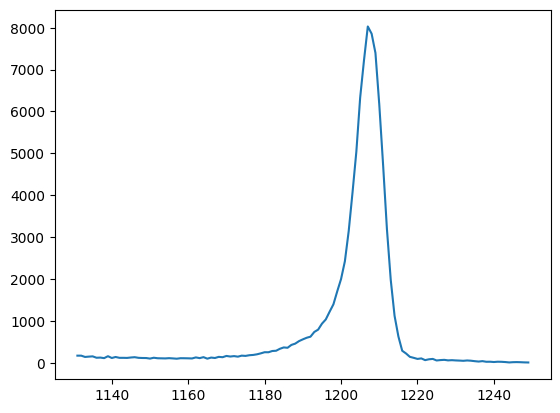

In [2]:
ROOT_PATH = '/Users/pabloherrero/sabat/RaTagging/RaTag/MCA_spectra'
file_spectrum = ROOT_PATH +'/Second_Th_loaded_detector_in_air.csv'
df_mca = pd.read_csv(file_spectrum, sep='\t', header=0, skiprows=11, nrows=2048, names=['counts'])
dfdw = df_mca[(df_mca.index > 1130)]
dff = dfdw[(dfdw.index < 1250)]

plt.plot(dff.counts, label='Spectrum with Th')
# plt.gca().set(xlim=(1400, 1630))

curve_fit → A =11.677, β=0.980, m=1.971, loc=1207.379, scale=3.431


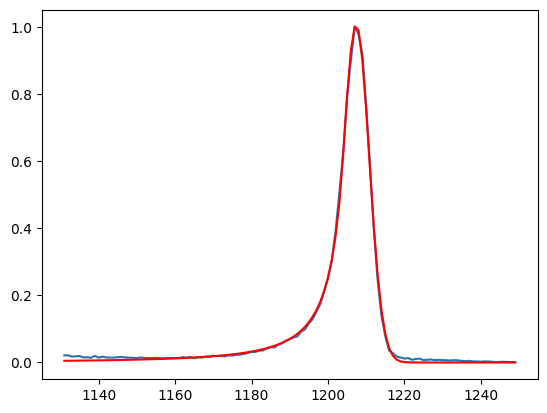

In [3]:
# 2) build PDF function
def crystalball_pdf(x, A, beta, m, loc, scale):
    return A * crystalball.pdf(x, beta, m, loc, scale)

# 3) histogram to get “y” values

# 4) initial guesses: reasonable defaults
x = dff.index.tolist()
x = np.array(x)

y = dff.counts.values
y = y.astype(float)
y /= np.max(y)  # normalize counts
p01 = [22.677, 1.150, 1.728, 1207.379, 7.329]

# 5) fit
popt, pcov = curve_fit(crystalball_pdf, x, y, p0=p01,
                       bounds=([0, 0, 0, np.min(x), 0],
                               [np.inf, np.inf, np.inf, np.max(x), np.inf]))

A, beta, m, loc, scale = popt
print(f"curve_fit → A ={A:.3f}, β={beta:.3f}, m={m:.3f}, loc={loc:.3f}, scale={scale:.3f}")

plt.plot(x, y, label='MCA')
plt.plot(x, crystalball_pdf(x, *popt), 'r-', label="fit")

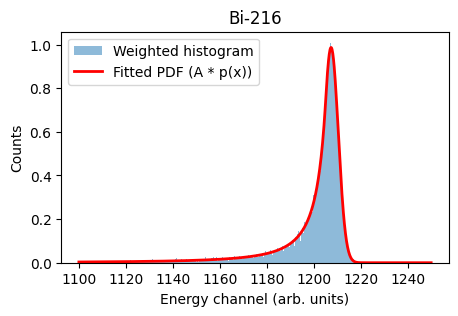

In [25]:
# Fitted parameters

beta = 0.76
m = 2.07
loc = 1207.37868
scale = 3.07

# Create Crystal Ball distribution
cb = crystalball(beta=beta, m=m, loc=loc, scale=scale)

# Draw samples
N = 50_000
u = np.random.uniform(1e-9, 1 - 1e-9, N)
samples = cb.ppf(u)

# Restrict to range of interest without clipping (for histogram)
xmin, xmax = 1100, 1250

# Histogram parameters
bins = 1000
bin_width = (xmax - xmin) / bins
weights = np.full_like(samples, A / (N * bin_width))

x = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots(figsize=(5, 3))

# Raw weighted histogram (counts per bin scaled to match A*p(x))
ax.hist(samples, bins=bins, range=(xmin, xmax), weights=weights, alpha=0.5, label="Weighted histogram")

# Fitted curve A*p(x)
ax.plot(x, A * cb.pdf(x), 'r-', lw=2, label="Fitted PDF (A * p(x))")

ax.set(xlabel="Energy channel (arb. units)", ylabel="Counts", title="Bi-216")
ax.legend()
plt.show()


# Simulate Th-228 and Ra-224 decays with main BR

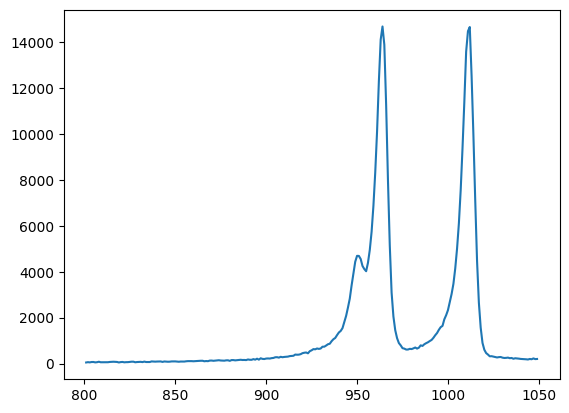

In [5]:
ROOT_PATH = '/Users/pabloherrero/sabat/RaTagging/RaTag/MCA_spectra'
file_spectrum = ROOT_PATH +'/Second_Th_loaded_detector_in_air.csv'
df_mca = pd.read_csv(file_spectrum, sep='\t', header=0, skiprows=11, nrows=2048, names=['counts'])
dfdw = df_mca[(df_mca.index > 800)]
dff = dfdw[(dfdw.index < 1050)]

plt.plot(dff.counts, label='Spectrum with Th')
# plt.gca().set(xlim=(1400, 1630))

In [6]:
class DecayMode:
    """
    Represents a single alpha decay mode with a Crystal Ball distribution.
    """
    def __init__(self, name, loc, beta, m, scale, branching_ratio):
        self.name = name
        self.loc = loc
        self.beta = beta
        self.m = m
        self.scale = scale
        self.branching_ratio = branching_ratio
        # Create normalized crystal ball distribution
        self.dist = crystalball(beta=self.beta, m=self.m, loc=self.loc, scale=self.scale)

    def sample(self, n_events, seed=None):
        """
        Generate samples for this decay mode via inverse transform sampling.
        """
        if seed is not None:
            rng = np.random.default_rng(seed)
        else:
            rng = np.random
        u = rng.uniform(1e-9, 1 - 1e-9, n_events)
        return self.dist.ppf(u)


class SpectrumSimulator:
    """
    Simulates a combined alpha-decay energy spectrum from multiple decay modes.
    """
    def __init__(self, decay_modes):
        self.decay_modes = decay_modes

    def simulate(self, total_events, seed=None):
        """
        Generate a combined sample of total_events across all decay modes,
        allocating counts according to branching ratios.
        Returns a dict mapping mode names to individual samples, and an array of all samples.
        """
        rng = np.random.default_rng(seed)
        results = {}
        all_samples = []
        # Allocate events per mode
        for mode in self.decay_modes:
            n_mode = int(np.round(mode.branching_ratio * total_events))
            samples = mode.sample(n_mode, seed=rng.integers(1e9))
            results[mode.name] = samples
            all_samples.append(samples)
        combined = np.concatenate(all_samples)
        rng.shuffle(combined)
        return results, combined

In [7]:
def histogram_decay(decays, bins=1000, xmin=5200, xmax=9000, col='blue', ax=None, label=None, total_events=None):
    """
    Plot a histogram for a decay mode using weights proportional to its contribution
    to the total spectrum based on branching ratio.

    If total_events is provided, the histogram will be scaled accordingly.
    """
    bin_width = (xmax - xmin) / bins
    if total_events is None:
        # Normalize independently
        weights = np.full_like(decays, 1 / (len(decays) * bin_width))
    else:
        # Normalize relative to total simulated events
        weights = np.full_like(decays, 1 / (total_events * bin_width))

    if ax is None:
        ax = plt.gca()

    n, bins, _ = ax.hist(decays, bins=bins, range=(xmin, xmax), weights=weights,
            alpha=0.9, color=col, label=label)
    ax.set(xlabel="Energy (channel)", ylabel="Normalized Counts", title="Decay Spectra")

    return n, bins

## In channel scale

In [10]:
cb3_x0 = 1011
cb2_x0 = 964
cb1_x0 = 949

[Text(0, 0.5, 'Channel'),
 Text(0.5, 0, 'Energy (keV)'),
 Text(0.5, 1.0, 'Energy Calibration')]

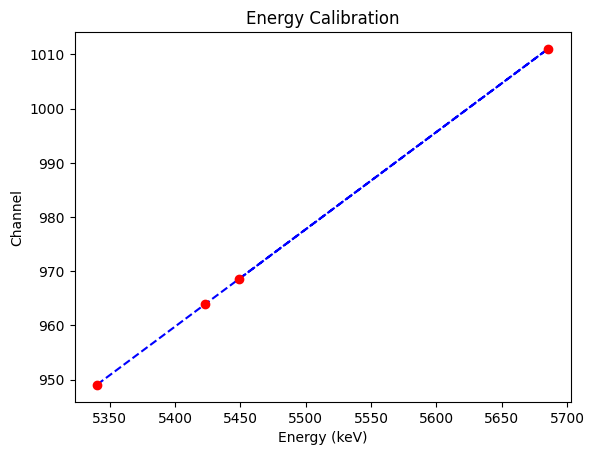

In [11]:
channels = [cb1_x0, cb2_x0, cb3_x0]
energies = [5340.36, 5423.15, 5685.37]
def linear(x, a, b):
    return a * x + b
popt, _ = curve_fit(linear, energies, channels)
energies.append(5448.6)  # Add Ra-224 5449 keV peak
channel_ra224_5449 = linear(5448.6, *popt)
channels.append(channel_ra224_5449)
plt.plot(energies, linear(np.array(energies), *popt), 'b--', label='Linear Fit')
plt.plot(energies, channels, 'ro', label='Crystal Ball Peaks')
plt.gca().set(ylabel='Channel', xlabel='Energy (keV)', title='Energy Calibration')

In [12]:
channel_ra224_5449

968.4958765339175

Th228_5423keV: 722000 events
Th228_5340keV: 150000 events
Ra224_5686keV: 722000 events
Ra224_5449keV: 38000 events


/var/folders/tb/zxwsw51n6_g6gs5lnxdv2bcr0000gn/T/ipykernel_44196/288329251.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['counts_norm'] = dff['counts'] / np.max(dff.counts) * np.max(n_th)


[(820.0, 1050.0)]

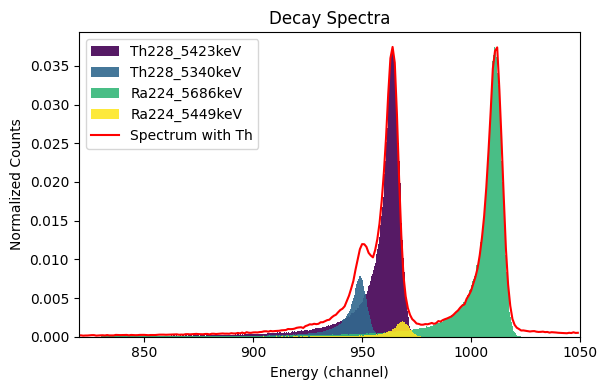

In [13]:
beta = beta
m = m
scale = scale
# Define decay modes for Th-228 and Ra-224
modes = [
    DecayMode(name="Th228_5423keV", loc=cb2_x0, beta=beta, m=m, scale=scale, branching_ratio=0.722),
    DecayMode(name="Th228_5340keV", loc=cb1_x0, beta=beta, m=m, scale=scale, branching_ratio=0.15),#0.278),
    DecayMode(name="Ra224_5686keV", loc=cb3_x0, beta=beta, m=m, scale=scale, branching_ratio=0.722),#0.949),
    DecayMode(name="Ra224_5449keV", loc=channel_ra224_5449, beta=beta, m=m, scale=scale, branching_ratio=0.038), #0.051),
    ]

simulator = SpectrumSimulator(modes)
results, spectrum = simulator.simulate(total_events=1_000_000)

fig, ax = plt.subplots(figsize=(6, 4))
total_events = sum(len(v) for v in results.values())

colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

for i,k in enumerate(results):
    print(f"{k}: {len(results[k])} events")
    n, bins = histogram_decay(results[k], xmin=830, xmax=1200, col=colors[i], bins=1000, ax=ax, label=k, total_events=total_events)
    if k == 'Th228_5423keV':
        n_th = n

dff['counts_norm'] = dff['counts'] / np.max(dff.counts) * np.max(n_th)
plt.plot(dff['counts_norm'], 'r-', label='Spectrum with Th')

ax.legend()
plt.tight_layout()
plt.gca().set(xlim=(820, 1050), )

/var/folders/tb/zxwsw51n6_g6gs5lnxdv2bcr0000gn/T/ipykernel_44196/2682089448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['counts_norm'] = dff['counts'] / np.max(dff.counts) * np.max(n)


[Text(0.5, 0, 'Energy (Channel)'),
 Text(0, 0.5, 'Normalized Counts'),
 Text(0.5, 1.0, 'Decay Spectrum Simulation')]

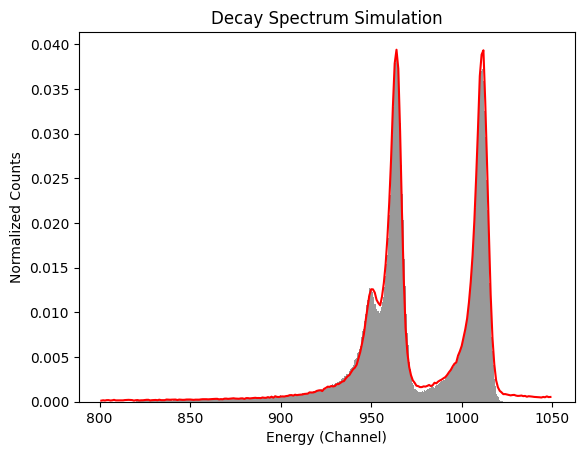

In [14]:
n, bi, _ = plt.hist(spectrum, bins=1000, range=(820, 1050), weights=np.full_like(spectrum, 1 / (len(spectrum) * (1050 - 820) / 1000)), alpha=0.8, label='Simulated Spectrum', color='gray');
dff['counts_norm'] = dff['counts'] / np.max(dff.counts) * np.max(n)

plt.plot(dff['counts_norm'], 'r-', label='Spectrum with Th')
plt.gca().set(xlabel='Energy (Channel)', ylabel='Normalized Counts', title='Decay Spectrum Simulation')


# Define SNR

In [16]:
decays0 = sorted(results['Ra224_5449keV'])
decays0 = np.array(decays0)
resolution = decays0[1:] - decays0[:-1]
print(f"Average resolution: {np.mean(resolution):.2f} keV")

Average resolution: 2.26 keV


In [15]:
tp = len(results['Th228_5340keV']) + len(results['Th228_5423keV']) 
tn = len(results['Ra224_5686keV']) + len(results['Ra224_5449keV'])
SNR = tp/np.sqrt(tn)
SNR

1000.2525996756493

# Define SNR as function of channel cuts

In [17]:
cutdw = 800
cutup = 980
def get_snr(results, cutdw, cutup):
    """
    Calculate the efficiency of the detector based on the given cuts.
    """
    results_cut = {k: v[(v >= cutdw) & (v <= cutup)] for k, v in results.items()}
    tp = len(results_cut['Th228_5340keV']) + len(results_cut['Th228_5423keV'])
    tn = len(results_cut['Ra224_5686keV']) + len(results_cut['Ra224_5449keV'])
    return tp / np.sqrt(tn)
    

[Text(0.5, 0, 'Upper energy cut (channel)'),
 Text(0, 0.5, 'SNR'),
 Text(0.5, 1.0, 'SNR vs Upper Energy Cut')]

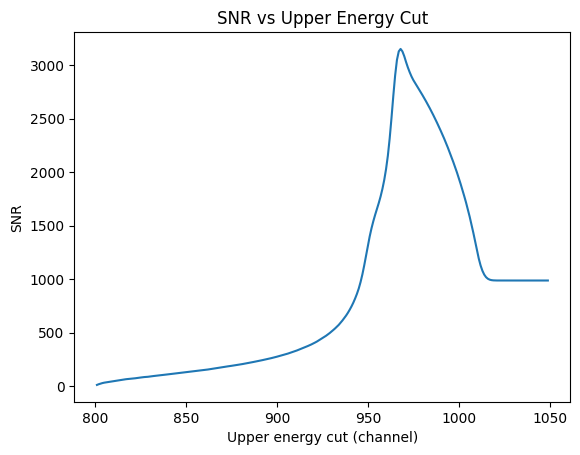

In [18]:
cutup = np.arange(801, 1050, 1)
snrs = [get_snr(results, cutdw, cu) for cu in cutup]
plt.plot(cutup, snrs)
plt.gca().set(xlabel = 'Upper energy cut (channel)', ylabel = 'SNR', title='SNR vs Upper Energy Cut')

In [19]:
cutup[np.argmax(snrs)]

968

Th228_5423keV: 722000 events
Th228_5340keV: 150000 events
Ra224_5686keV: 722000 events
Ra224_5449keV: 38000 events


NameError: name 'effs' is not defined

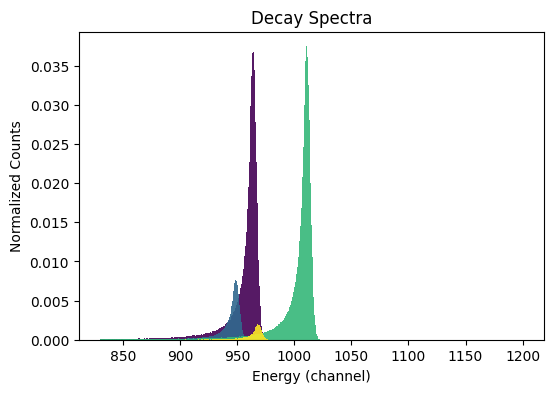

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
total_events = sum(len(v) for v in results.values())

colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

for i,k in enumerate(results):
    print(f"{k}: {len(results[k])} events")
    histogram_decay(results[k], xmin=830, xmax=1200, col=colors[i], bins=1000, ax=ax, label=k, total_events=total_events)
ax.axvline(x=cutup[np.argmax(effs)], color='r', linestyle='--', label='Optimal Upper Cut')
ax.legend()
plt.tight_layout()
plt.gca().set(xlim=(820, 1030), )

## Estimate Bg count rate

In [21]:
def get_background_rate(results, low_cut, high_cut):
    """
    Calculate the background rate in the specified energy range.
    """
    ra_vals = np.concatenate([results['Ra224_5686keV'], results['Ra224_5449keV']])
    n_ra_in_cut = np.count_nonzero((ra_vals >= low_cut) & (ra_vals <= high_cut))
    background_rate = n_ra_in_cut / sum(len(v) for v in results.values()) * 100
    # background_rate = fraction_of_ra / (high_cut - low_cut)  # Approximate rate per channel
    return background_rate

low_cut = 800
high_cut = cutup[np.argmax(snrs)]
background_rate = get_background_rate(results, low_cut, high_cut)
print(f"Background rate in range ({low_cut}, {high_cut}): {background_rate:.4f} percent")

Background rate in range (800, 968): 4.0364 percent


[Text(0.5, 0, 'Upper energy cut (channel)'),
 Text(0, 0.5, 'Bg rate (Ra / total events)'),
 Text(0.5, 1.0, 'Bg rate vs Upper Energy Cut')]

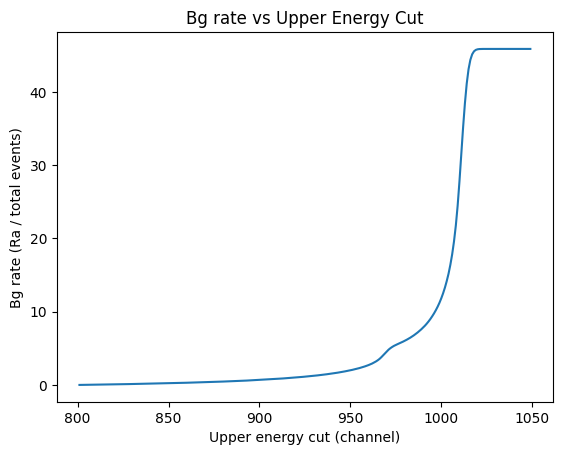

In [22]:
cutup = np.arange(801, 1050, 1)
bg_rates = [get_background_rate(results, cutdw, cu) for cu in cutup]
plt.plot(cutup, bg_rates)
plt.gca().set(xlabel = 'Upper energy cut (channel)', ylabel = 'Bg rate (Ra / total events)', title='Bg rate vs Upper Energy Cut')

## Transform to energy scale

In [23]:
beta = beta
m = m
scale = scale
# Define decay modes for Th-228 and Ra-224
modes = [
    DecayMode(name="Th228_5423keV", loc=5423.15, beta=beta, m=m, scale=scale, branching_ratio=0.722),
    DecayMode(name="Th228_5340keV", loc=5340.36, beta=beta, m=m, scale=scale, branching_ratio=0.278),
    DecayMode(name="Ra224_5686keV", loc=5685.37, beta=beta, m=m, scale=scale, branching_ratio=0.949),
    DecayMode(name="Ra224_5449keV", loc=5448.6, beta=beta, m=m, scale=scale, branching_ratio=0.051),]

simulator = SpectrumSimulator(modes)
results, spectrum = simulator.simulate(total_events=1_000_000)


Th228_5423keV: 722000 events
Th228_5340keV: 278000 events
Ra224_5686keV: 949000 events
Ra224_5449keV: 51000 events


[(5200.0, 5720.0)]

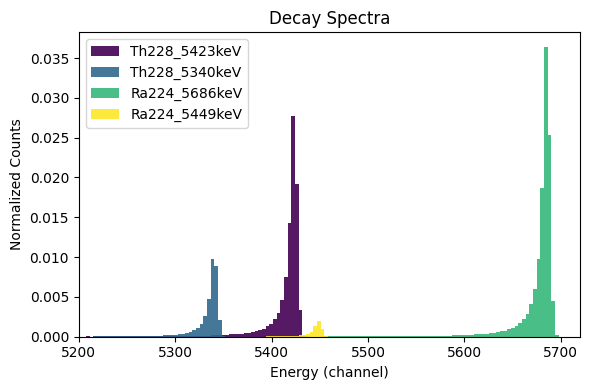

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
total_events = sum(len(v) for v in results.values())

colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

for i,k in enumerate(results):
    print(f"{k}: {len(results[k])} events")
    n, bins = histogram_decay(results[k], col=colors[i], bins=1000, ax=ax, label=k, total_events=total_events)
ax.legend()
plt.tight_layout()
plt.gca().set(xlim=(5200, 5720), )


## Transform to Voltage scale

In [ ]:
def get_total_gain(dial, coarse_gain = 50):
    Gmin = 0.5
    Gmax = 1.5
    dmin = 0
    dmax = 100
    Gfine = Gmin + (Gmax - Gmin) * (dial - dmin) / (dmax - dmin)
    Gtotal = Gfine * coarse_gain
    return Gtotal

def channel_to_voltage(channel):
    """
    Convert a channel number to voltage and energy peak.
    :param channel: Channel number (0-2047)
    :return: event voltage in mV
    """
    if not (0 <= channel < 2048):
        raise ValueError("Channel must be between 0 and 2047")
    
    V = channel * 10 / 2048 # V
    V_mV = V * 1000 # mV

    # print(f"V = {V:.2f} V")
    return V_mV

def voltage_to_energy(voltage, fine_gain = 63, coarse_gain = 50):
    """
    Convert a voltage in mV to energy peak in eV.
    :param voltage: Voltage in mV
    :param fine_gain: Fine gain setting (0-63)
    :param coarse_gain: Coarse gain setting (default 50)
    :return: Energy peak in eV
    """
    gain_amp = get_total_gain(fine_gain, coarse_gain)
    gain_preamp = 45 / 1000 # mV / keV preamp gain

    E_peak = voltage / (gain_amp * gain_preamp)# keV
    print(f"E_peak = {E_peak:.2f} KeV")
    return E_peak

In [ ]:
len(results['Ra224_5449keV'][results['Ra224_5449keV'] < 0]), len(results['Ra224_5449keV'])

(126, 38000)

In [ ]:
results_V = {}
for decay in results.keys():
    positive_channels = results[decay][results[decay] > 0]
    decay_v = [*map(channel_to_voltage, positive_channels)]
    results_V[decay] = np.array(decay_v)

In [ ]:
def histogram_decay(decays, bins=1000, xmin=5200, xmax=9000, col='blue', ax=None, label=None, total_events=None):
    """
    Plot a histogram for a decay mode using weights proportional to its contribution
    to the total spectrum based on branching ratio.

    If total_events is provided, the histogram will be scaled accordingly.
    """
    bin_width = (xmax - xmin) / bins
    if total_events is None:
        # Normalize independently
        weights = np.full_like(decays, 1 / (len(decays) * bin_width))
    else:
        # Normalize relative to total simulated events
        weights = np.full_like(decays, 1 / (total_events * bin_width))

    if ax is None:
        ax = plt.gca()

    n, bins, _ = ax.hist(decays, bins=bins, range=(xmin, xmax), weights=weights,
            alpha=0.9, color=col, label=label)
    ax.set(xlabel="Energy (channel)", ylabel="Normalized Counts", title="Decay Spectra")

    return n, bins

In [ ]:
N = 10
M = 2
L = 199
results = []
for i in range(N):
    s1 = np.random.uniform(0, 1, L).tolist()
    s2 = np.random.uniform(0, 1, L).tolist()
    results.append([s1, s2])

In [ ]:
s1s = [r[0] for r in results]
s2s = [r[1] for r in results] 
s1s = np.array(s1s)
s2s = np.array(s2s)
s1s = s1s.flatten()
s2s = s2s.flatten()


(1990,)

In [ ]:
for decay in results_V.keys():
    print(f"{decay}: {len(results_V[decay])} events")
    n, bins = histogram_decay(results_V[decay], col=colors[i], bins=1000, xmin=1000., xmax=8000., ax=ax, label=decay, total_events=total_events)

Th228_5423keV: 719786 events
Th228_5340keV: 149540 events
Ra224_5686keV: 719940 events
Ra224_5449keV: 37874 events


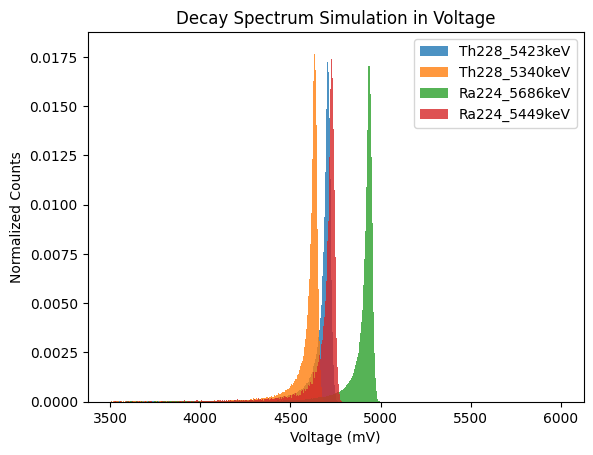

In [ ]:
# plt.hist(results_V['Ra224_5449keV'], range=(3500, 6000), bins=1000, weights=np.full_like(results_V['Ra224_5449keV'], 1 / (len(results_V['Ra224_5449keV']) * (6000 - 3500) / 1000)), alpha=0.8, label='Simulated Ra-224 5449 keV Spectrum');
for decay in results_V.keys():
    plt.hist(results_V[decay], range=(3500, 6000), bins=1000, weights=np.full_like(results_V[decay], 1 / (len(results_V[decay]) * (6000 - 3500) / 1000)), alpha=0.8, label=decay);

plt.gca().set(xlabel='Voltage (mV)', ylabel='Normalized Counts', title='Decay Spectrum Simulation in Voltage')
plt.legend()

# Full spectrum

In [ ]:
class AlphaDecay:
    """
    Represents an alpha-decay isotope with time distribution and optional energy.
    """
    def __init__(self, name, energy_keV, half_life_s, beta=None, m=None, scale=None,
                 branching_ratio=1.0, next_decay=None):
        self.name = name
        self.energy_keV = energy_keV
        self.half_life_s = half_life_s
        self.branching_ratio = branching_ratio
        self.next_decay = next_decay
        # Only create Crystal Ball if energy provided
        if energy_keV is not None:
            self.cb_dist = crystalball(beta=beta, m=m, loc=energy_keV, scale=scale)
        else:
            self.cb_dist = None



In [ ]:
def simulate_chain(start_decay, n_chains, observation_window_s=None, seed=None):
    """
    Simulate n_chains decay chains from `start_decay`.
    Returns list of events with keys ['chain','mode','time_s','energy_keV'].
    If observation_window_s is set, only events with time_s <= window are recorded.
    """
    rng = np.random.default_rng(seed)
    events = []
    for cid in range(n_chains):
        t = 0.0
        decay = start_decay
        while decay:
            # draw decay time
            dt = rng.exponential(scale=decay.half_life_s / np.log(2))
            t += dt
            # stop if beyond observation window
            if observation_window_s is not None and t > observation_window_s:
                break
            # branching decision
            if rng.random() <= decay.branching_ratio:
                # sample energy if available
                if decay.cb_dist is not None:
                    E = decay.cb_dist.ppf(rng.uniform(1e-9, 1 - 1e-9))
                    events.append({'chain': cid,
                                   'mode': decay.name,
                                   'time_s': t,
                                   'energy_keV': E})
            # move to next decay in chain
            decay = decay.next_decay
    return events


def plot_energy_spectrum(events, modes=None, bins=1000, xmin=None, xmax=None):
    """
    Overlay energy histograms for specified decay modes.
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    labels = sorted({e['mode'] for e in events})
    for label, color in zip(labels, plt.cm.tab10.colors):
        if modes and label not in modes:
            continue
        energies = [e['energy_keV'] for e in events if e['mode'] == label]
        ax.hist(energies, bins=bins, range=(xmin, xmax), alpha=0.5,
                label=label, color=color)
    ax.set_xlabel("Energy (keV)")
    ax.set_ylabel("Counts")
    ax.legend()
    ax.set_title("Simulated Alpha Energy Spectrum")
    plt.tight_layout()
    return fig, ax


def plot_time_differences(events, mode_pair=None, bins=100, tmax=None):
    """
    Histogram of time differences between successive decays in each chain.
    If mode_pair=(m1,m2), only include dt between those two modes.
    """
    from collections import defaultdict
    chains = defaultdict(list)
    for e in events:
        chains[e['chain']].append(e)
    dt_list = []
    for evs in chains.values():
        evs_sorted = sorted(evs, key=lambda x: x['time_s'])
        for i in range(len(evs_sorted)-1):
            m1 = evs_sorted[i]['mode']
            m2 = evs_sorted[i+1]['mode']
            dt = evs_sorted[i+1]['time_s'] - evs_sorted[i]['time_s']
            if mode_pair is None or (m1, m2) == mode_pair:
                dt_list.append(dt)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(dt_list, bins=bins, range=(0, tmax), alpha=0.7)
    ax.set_xlabel("Time difference (s)")
    ax.set_ylabel("Counts")
    title = "Time differences"
    if mode_pair:
        title += f" from {mode_pair[0]} to {mode_pair[1]}"
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

In [ ]:
beta, m, scale = 0.98, 1.97, 3.43

In [ ]:
# Build chain including Pb-212 (no alpha), Bi-212, Po-212
po212 = AlphaDecay("Po212", 8954, half_life_s=0.299e-6,
                    beta=beta, m=m, scale=scale)
bi212 = AlphaDecay("Bi212", 6207, half_life_s=60.55*60,
                    beta=beta, m=m, scale=scale,
                    branching_ratio=0.359, next_decay=po212)
pb212 = AlphaDecay("Pb212", None, half_life_s=10.64*3600,
                    branching_ratio=1.0, next_decay=bi212)
po216 = AlphaDecay("Po216", 6906, half_life_s=0.145,
                    beta=beta, m=m, scale=scale,
                    next_decay=pb212)
rn220 = AlphaDecay("Rn220", 6405, half_life_s=55.6,
                    beta=beta, m=m, scale=scale,
                    next_decay=po216)
ra224b = AlphaDecay("Ra224", 5685, half_life_s=3.66*24*3600,
                    beta=beta, m=m, scale=scale,
                    next_decay=rn220)

ra224b = AlphaDecay("Ra224_B", 5448, half_life_s=3.66*24*3600,
                    beta=beta, m=m, scale=scale,
                    next_decay=rn220)
ra224 = AlphaDecay("Ra224", 5685, half_life_s=3.66*24*3600,
                    beta=beta, m=m, scale=scale,
                    next_decay=rn220)
th228b = AlphaDecay("Th228_B", 5340, half_life_s=1.9116*365.25*24*3600,
                    beta=beta, m=m, scale=scale,
                    next_decay=ra224)
th228 = AlphaDecay("Th228", 5423, half_life_s=1.9116*365.25*24*3600,
                    beta=beta, m=m, scale=scale,
                    next_decay=ra224)


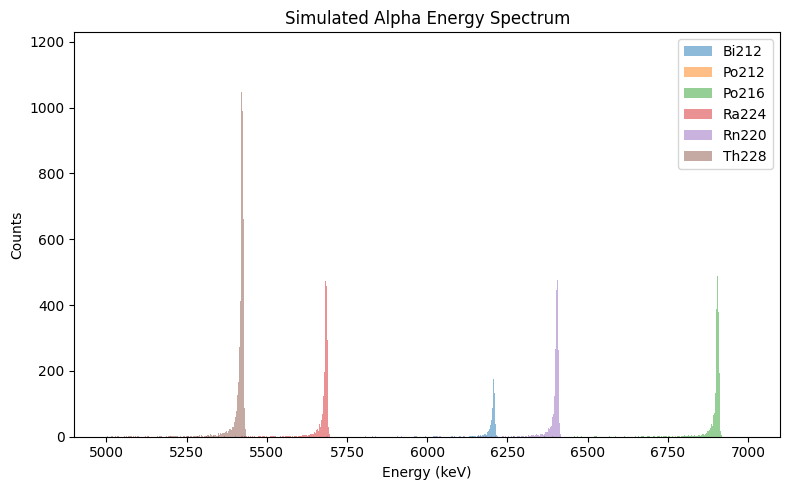

In [ ]:
observation_window_s = 7 * 24 * 3600  # 7 days in seconds
# Simulate with a 2-day observation window
events = simulate_chain(th228, n_chains=1_000_000,
                        observation_window_s=observation_window_s, seed=2025)
# Plot energy and time differences
plot_energy_spectrum(events, xmin=5000, xmax=7000)
plt.show()
